In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.interpolate import interp1d, interp2d

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from ipywidgets import interact, IntSlider

# Prepare

In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range.tail(10)

,min,max,mid
C_O2,5.391452e+06,1.419437e+09,7.124145e+08
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08
NO,1.006610e+05,9.000156e+11,4.500078e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11
NO3,1.742790e+06,1.039629e+10,5.199017e+09
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01


In [4]:
x0 = df_range['mid'].values
f0 = y0 = kpp.onestep(x0.T).T
x0.shape, y0.shape

((75,), (1, 74))

# 1st order HDMR

In [5]:
def hdmr_axis(n, res = 10):
    '''Sample along one axis'''
    x_list = np.empty([res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,n] = np.linspace(df_range['min'][n],df_range['max'][n], res)

    y1 = kpp.onestep(x_list.T).T - y0
    return y1, x_list[:,n]

In [6]:
# construct all 1-st order components
y1_list = [None]*(nvar+1)
x1_list = [None]*(nvar+1)

for n in range(nvar+1):
    y1_list[n], x1_list[n] = hdmr_axis(n)

In [7]:
# interpolate all HDMR components
f1 = []
for j_in in range(nvar+1):
    f1.append( interp1d(x1_list[j_in], y1_list[j_in].T) )

In [8]:
def eval_hdmr1(x, f0=f0, f1=f1):
    '''Evaluate 1-st order HDMR at x'''
    S = 0.0 # to hold the sum of all components
    
    # 1-st order components
    for j_in in range(nvar+1):
        S += f1[j_in](x[:,j_in]).T
    
    # 0-th order term
    S += f0
    return S

In [9]:
df_range['span'] = df_range['max'] - df_range['min']

In [10]:
#x_test = np.random.uniform(df_range['min'], df_range['max'], size=(5000, nvar+1))

x_test = np.random.uniform(df_range['min'] + 0.0*df_range['span'],
                           df_range['max'] - 0.0*df_range['span'], 
                           size=(5000, nvar+1))

x_test.shape

(5000, 75)

In [11]:
%time y_test_pred = eval_hdmr1(x_test)
y_test_pred.shape

CPU times: user 177 ms, sys: 8.04 ms, total: 185 ms
Wall time: 186 ms


(5000, 74)

In [12]:
%time y_test_true = kpp.onestep(x_test.T).T
y_test_true.shape

CPU times: user 4.32 s, sys: 55.7 ms, total: 4.38 s
Wall time: 4.41 s


(5000, 74)

In [13]:
r2_score(y_test_pred, y_test_true)

0.5662478286714826

In [14]:
r2_score(y_test_pred/df_range['max'][:-1].values, 
         y_test_true/df_range['max'][:-1].values)

0.56624782867148205

(0, 2)

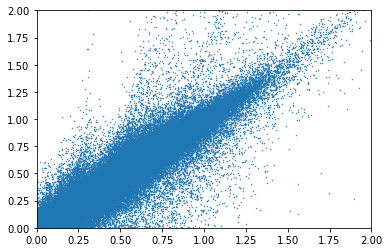

In [15]:
plt.scatter(y_test_pred/df_range['max'][:-1].values, 
            y_test_true/df_range['max'][:-1].values,
            s=0.2)
plt.xlim(0, 2)
plt.ylim(0, 2)

# 2-nd order HDMR

In [16]:
def hdmr_plane(n, m, res = 10):
    '''Sample along one 2D plane'''

    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)

    x_list = np.empty([res, res, nvar+1])
    x_list[:] = df_range['mid'].values
    x_list[:,:,n] = range_n.reshape(1,res)
    x_list[:,:,m] = range_m.reshape(res,1)

    y = kpp.onestep(x_list.reshape(res*res,-1).T).T.reshape(res,res,-1)
    
    # Use 1D axis to approximate 2D plane
    y_approx = y1_list[n].reshape(1, res, -1) + y1_list[m].reshape(res, 1, -1) + y0
    
    y2 = y - y_approx # store the differene in 2-nd order components

    return y2

In [17]:
%%time
# construct all 2-nd order components
y2_list = np.empty([nvar+1, nvar+1], dtype=object)
x2_list = np.empty([nvar+1, nvar+1], dtype=object)

for n in range(nvar+1):
    print(n, end=' ')
    for m in range(nvar+1):
        if m==n:
            break
        y2_list[n,m] = hdmr_plane(n, m)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 CPU times: user 3min 23s, sys: 1.64 s, total: 3min 25s
Wall time: 3min 28s


In [18]:
@interact(n=IntSlider(min=0,max=74,step=1,value=33,continuous_update=False),
          m=IntSlider(min=0,max=74,step=1,value=29,continuous_update=False),
          k=IntSlider(min=0,max=73,step=1,value=20,continuous_update=False))
def plot_2d_diff(n, m, k):
    
    if n < m:
        m, n = n, m
    if n == m:
        print('no 2D component for n=m')
        return
    
    res = 10 # determined by data
    
    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)
    
    # Use 1D axis to approximate 2D plane
    y2_approx = y1_list[n].reshape(1, res, -1) + y1_list[m].reshape(res, 1, -1) + y0
    
    ratio = y2_list[n,m][...,k]/y2_approx[...,k]
    ratio_range = np.max(np.abs(ratio))
    
    plt.pcolormesh(range_n, range_m, ratio,
                   cmap='bwr', vmin=-ratio_range, vmax=ratio_range)
    
    plt.xlabel(df_range.iloc[n].name)
    plt.ylabel(df_range.iloc[m].name)
    plt.title(df_range.iloc[k].name)
    
    plt.colorbar()
    plt.show()

## Interpolation

In [19]:
res = 10
n = 74 # SUN
range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)

# interpolate all HDMR components
f2_SUN = np.empty([nvar, nvar], dtype=object) # [input except SUN, output]

for m in range(nvar): # input except SUN
    range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)
    
    for k in range(nvar): # output variable
        # interp2d can only fit one level at a time
        f2_SUN[m,k] = interp2d(range_n, range_m, y2_list[n,m][...,k])

In [20]:
def eval_hdmr2_sun(x, f2_SUN=f2_SUN):
    '''
    Evaluate 2-nd order HDMR at x
    Only consider correlation with SUN. Skip other correlations
    '''
    S = eval_hdmr1(x)  # start with 1-st order approx
    
    for i, xi in enumerate(x): # data points
        for k in range(nvar): # output variable
            for m in range(nvar):
                S[i, k] += f2_SUN[m, k](xi[-1], xi[m])

    return S

## Test set

In [21]:
%time y_test_pred_2nd = eval_hdmr2_sun(x_test[:100])
y_test_pred_2nd.shape

CPU times: user 14.6 s, sys: 181 ms, total: 14.8 s
Wall time: 15 s


(100, 74)

In [22]:
r2_score(y_test_pred_2nd, y_test_true[:100])

0.85576653820031123

(0, 2)

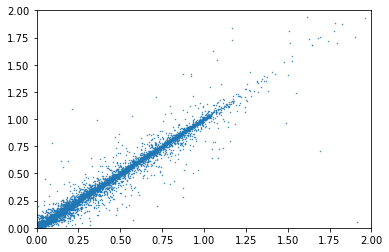

In [23]:
plt.scatter(y_test_pred_2nd/df_range['max'][:-1].values, 
            y_test_true[:100]/df_range['max'][:-1].values,
            s=0.2)
plt.xlim(0, 2)
plt.ylim(0, 2)

# Add more second-order terms

In [24]:
ratio_list = np.empty([nvar+1, nvar+1], dtype=object)

res = 10
for n in range(nvar+1):
    for m in range(nvar+1):
        if n <= m:
            break
        y2_approx = y1_list[n].reshape(1, res, -1) + y1_list[m].reshape(res, 1, -1) + y0
        ratio_list[n,m] = y2_list[n,m]/y2_approx

/Users/zhuangjw/Research/Computing/miniconda3/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [25]:
for n in range(nvar+1):
    count = 0
    for m in range(nvar+1):
        if n <= m:
            break
        max_temp = np.max(np.mean(np.abs(ratio_list[n,m]), axis=2))
        #max_temp = np.max(np.max(np.abs(ratio_list[n,m]), axis=2))
        if max_temp > 0.1:
            count += 1
            
    if count > 0:
        print(n, count)

15 1
19 2
20 2
22 1
23 1
25 3
29 3
30 2
36 1
38 1
43 3
46 2
48 2
49 1
52 1
54 4
55 2
61 33
62 1
65 1
68 7
69 10
71 1
73 1
74 61


In [26]:
[varnames[i] for i in [61, 68, 69]]

['O3', 'NO', 'NO2']

In [27]:
res = 10
n_list = [61, 68, 69] # species with significant correlation with others

f2_more = np.empty(len(n_list), dtype=object)

for ni, n in enumerate(n_list):
    f2_more[ni] = np.empty([n, nvar], dtype=object)
    range_n = np.linspace(df_range['min'][n], df_range['max'][n], res)

    for m in range(n): # from 0 to n
        range_m = np.linspace(df_range['min'][m], df_range['max'][m], res)

        for k in range(nvar): # output variable
            f2_more[ni][m,k] = interp2d(range_n, range_m, y2_list[n,m][...,k])

In [28]:
def eval_hdmr2_more(x, f2_more=f2_more):
    '''
    Add more 2nd-order components
    '''
    S = eval_hdmr2_sun(x)  # start with previous 2nd-order approx
    
    for i, xi in enumerate(x): # data points
        for ni, n in enumerate(n_list):
            for m in range(n):
                for k in range(nvar): # output variable
                     # remember to use n for input, not -1 anymore
                    S[i, k] += f2_more[ni][m,k](xi[n], xi[m])

    return S

## Test

In [29]:
%time y_test_pred_2nd_more = eval_hdmr2_more(x_test[:100])
y_test_pred_2nd_more.shape

CPU times: user 50.4 s, sys: 312 ms, total: 50.7 s
Wall time: 51 s


(100, 74)

In [30]:
r2_score(y_test_pred_2nd_more, y_test_true[:100])

0.95409297110933367

(0, 2)

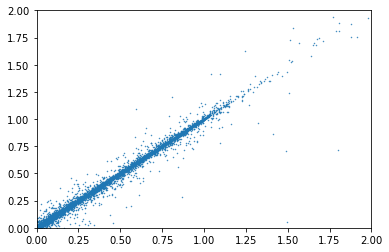

In [32]:
plt.scatter(y_test_pred_2nd_more/df_range['max'][:-1].values, 
            y_test_true[:100]/df_range['max'][:-1].values,
            s=0.2)
plt.xlim(0, 2)
plt.ylim(0, 2)

In [33]:
np.mean(np.abs((y_test_pred_2nd_more-y_test_true[:100])/df_range['max'][:-1].values))

0.017990157974640188

In [34]:
np.mean(np.abs((y_test_pred_2nd-y_test_true[:100])/df_range['max'][:-1].values))

0.027820372391585108